In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

train_set_x = mnist_trainset.data.numpy()
test_set_x = mnist_testset.data.numpy()
train_set_y = mnist_trainset.targets.numpy()
test_set_y = mnist_testset.targets.numpy()

# We choose only images with 0 or 1 label using masking. Then we flatten our data using .reshape()
mask_train = [(train_set_y == 1) | (train_set_y == 0)]
mask_test = [(test_set_y == 1) | (test_set_y == 0)]

train_set_x = train_set_x[mask_train].reshape(-1, 784)
test_set_x = test_set_x[mask_test].reshape(-1, 784)
train_y = train_set_y[mask_train]
test_y = test_set_y[mask_test]

In [ ]:
def transform(train_data, test_data, n_pca=2, scale = True, squeeze = False):
    """
    Applying PCA and MinMaxScaler
    """
    pca = PCA(n_components=n_pca)
    tr_data = pca.fit_transform(train_data)
    ts_data = pca.transform(test_data)

    if squeeze:
      tr_data = tr_data.squeeze()
      ts_data = ts_data.squeeze()

    if scale:
      min = tr_data.min(axis=0)
      max = tr_data.max(axis=0)
      tr_data = (tr_data - min) / (max - min)
      ts_data = (ts_data - min) / (max - min)
    return tr_data, ts_data

def error(y_test, y_pred):
    """
    Prediction error we will use in this assignment
    """
    return (y_pred != y_test).mean()

def compute_confusion_matrix(y_test, y_pred):
    """
    Computing a confusion matrix
    """

    K = len(np.unique(y_test))
    result = np.zeros((K, K))

    for i in range(len(y_test)):
      result[y_test[i]][y_pred[i]] += 1

    return result

###Exercise 1: Non-Parametric Estimation###

In [ ]:
train1d_x, test1d_x = transform(train_set_x, test_set_x, n_pca = 1, scale = 0, squeeze = True)
print(train1d_x.shape, train_y.shape, test1d_x.shape, test_y.shape)

(12665,) (12665,) (2115,) (2115,)


**Performing histogram estimation**

Number of histogram bins we will need: $b = ceil[\frac{max(X) - min(X)}{r}]$ 

j = 0, 1, 2, ..., b − 1 are the indices of the
different bins. A point $x_{i} ∈ X$ belongs to bin $j_{i}$:

$$j_{i} = floor[\frac{x_{i} - min(X)}{r}]$$ For bin j,
the number of points in the bin $M_{j}$ is given by

\begin{align}
        \text M_{j} = \sum_{i=1}^n \left\{
        \begin{array}{cl}
        1, & j = j_{i} = [\frac{x_{i} - min(X)}{r}] \\
        0, & otherwise
        \end{array}
        \right.
    \end{align}

The corresponding probability for bin j - the height of a histogram:

$$\hat{H}_{j} = \frac{M_{j}}{N*r}$$

**Making predictions using the histogram we have constructed**

\begin{align}
        \hat{p}(x) = \left\{
        \begin{array}{cl}
        \hat{H}_{j}, & j = [\frac{x_{i} - min(X)}{r}] \\
        0, & \text {if  } x<h_{min} \text {or  } x>=h_{max}
        \end{array}
        \right.
    \end{align}

In [ ]:
def fit_hist(X, r):
    """
    X - 1-dimensional array of training data
    r - scalar value representing the bin width, or resolution
    """
    minX = X.min()
    maxX = X.max()
    # the number of bins we need
    b = int(np.ceil((maxX - minX)/r))

    # the bounds of our histogram
    h_min = minX
    h_max = minX + b*r

    # the bin indices for data points
    j_indices = [np.floor((x - minX)/r).astype(int) if x !=maxX else b-1 for x in X]

    # the number of points in the bin
    M = np.zeros(b, dtype=np.float32)
    for j in j_indices:
        M[j] += 1

    # probabilities for bins
    N = X.shape[0]
    H_hat = M/(N*r)
    return H_hat, h_min, h_max


def predict_hist(X_test, H_hat, h_min, h_max, r):
    """
    X_test - 1-dimensional array of test data
    H_hat, h_min, h_max - result of fit_histogram
    r - scalar value representing the bin width
    """
    # points that fall in range [h_min, h_max)
    non_zero_idx = (X_test >= h_min) & (X_test < h_max)
    # Find the indices for the non-zero probability points
    # We use the Hj part of Equation (6) for this, making sure we only
    # use the points we identified in the previous step
    j_indices = np.floor((X_test[non_zero_idx] - h_min)/r).astype(int)

    p_hat = np.zeros(len(X_test), dtype=np.float32)
    p_hat[non_zero_idx] = H_hat[j_indices]
    return p_hat

In [ ]:
def plot_hist(X, labels, r):
    """
    Plots histogram for each class of binary data
    X - 1-dimensional array of training data
    labels - binary labels for X
    r - scalar value representing the bin width, or resolution
    """
    c0 = X[labels == 0]
    c1 = X[labels == 1]
    hist0, h_min0, h_max0 = fit_hist(c0, r)
    hist1, h_min1, h_max1 = fit_hist(c1, r)

    x_test = np.linspace(X.min() - 2*r, X.max() + 2*r, 5000)
    p0 = predict_hist(x_test, hist0, h_min0, h_max0, r)
    p1 = predict_hist(x_test, hist1, h_min1, h_max1, r)

    plt.figure()
    plt.plot([], [], ' ', label=f'Bin width:{r}')
    plt.plot(x_test, p0, 'purple', label='Histogram for class 0')
    plt.plot(x_test, p1, 'orange', label='Histogram for class 1')
    plt.xlabel('$x$')
    plt.ylabel('$\hat{p}$')
    plt.legend(loc='upper right')
    plt.show()

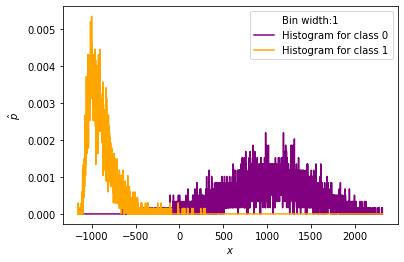

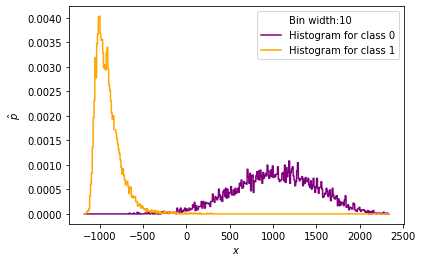

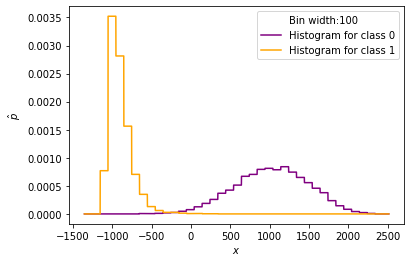

In [ ]:
R = [1, 10, 100]
for i in R:
    plot_hist(train1d_x, train_y, i)

In [ ]:
def MLclf_hist(X, labels, test, r):
    """
    ML classifier that uses the estimated distributions to predict labels of test data
    X - 1-dimensional array of training data
    labels - binary labels for X
    r - scalar value representing the bin width, or resolution
    """
    c0 = X[labels == 0]
    c1 = X[labels == 1]
    hist0, h_min0, h_max0 = fit_hist(c0, r)
    hist1, h_min1, h_max1 = fit_hist(c1, r)

    p0 = predict_hist(test, hist0, h_min0, h_max0, r)
    p1 = predict_hist(test, hist1, h_min1, h_max1, r)

    y_pred = [0 if p0[i] - p1[i] > 0 else 1 for i in range(len(p0))]

    return np.asarray(y_pred)

Region sizes of 10 and 100 are better in terms of the test error than 1, as such a small resolution makes a bar height at each bin suffer from significant statistical fluctuation due to insufficiency of samples in each bin. But if we make region size too big (in our case, r=1500), histogram would not accurately represent a shape of the underlying distribution.

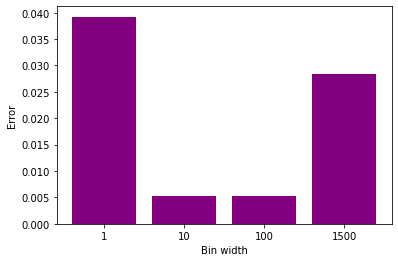

In [ ]:
R = [1, 10, 100, 1500]

values = [error(test_y,  MLclf_hist(train1d_x, train_y, test1d_x, r)) for r in R]
plt.bar([str(r) for r in R], values, color = 'purple')
plt.xlabel('Bin width')
plt.ylabel('Error')
plt.show()

In [ ]:
def gaussian_window(X):
    return np.exp(-0.5*X**2)/np.sqrt(2*np.pi)

def predict_parzen(X, test, s, phi = gaussian_window):
    """
    X is a 1-dimensional array of training data
    X_test is a 1-dimensional array of test data (i.e., shape (Ntest,)).
    s - user-defined scaling factor
    phi - window function
    """
    N = X.shape[0]
    dists_scaled = (test[np.newaxis, :] - X[:, np.newaxis])/s
    phi_vals = phi(dists_scaled).sum(axis=0)

    N = len(X)
    p_hat = phi_vals/(N*s)
    return p_hat

In [ ]:
def plot_parzen(X, labels, s, phi = gaussian_window):
    """
    Plots parzen estimates for each class of binary data
    X - 1-dimensional array of training data
    labels - binary labels for X
    s - user-defined scaling factor
    phi - window function
    """
    c0 = X[labels == 0]
    c1 = X[labels == 1]

    x_test = np.linspace(X.min() - 2*s, X.max() + 2*s, 5000)
    p0 = predict_parzen(c0, x_test, s, phi)
    p1 = predict_parzen(c1, x_test, s, phi)

    plt.figure()
    plt.plot([], [], ' ', label=f'Scaling factor:{s}')
    plt.plot(x_test, p0, 'purple', label='Parzen for class 0')
    plt.plot(x_test, p1, 'orange', label='Parzen for class 1')
    plt.xlabel('$x$')
    plt.ylabel('$\hat{p}$')
    plt.legend(loc='upper right')
    plt.show()

It can be clearly observed that estimated distributions using kernel resulted in more smooth plots.

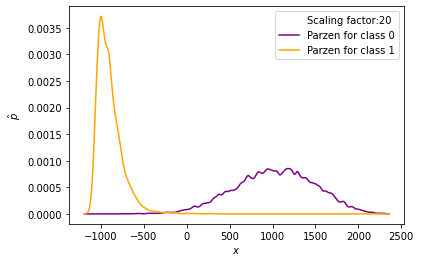

In [ ]:
s_p = 20
plot_parzen(train1d_x, train_y, s_p)

In [ ]:
def MLclf_parzen(X, labels, test, s, phi = gaussian_window):
    """
    ML classifier that uses the estimated distributions to predict labels of test data
    X - 1-dimensional array of training data
    labels - binary labels for X
    r - scalar value representing the bin width, or resolution
    """
    c0 = X[labels == 0]
    c1 = X[labels == 1]

    p0 = predict_parzen(c0, test, s, phi)
    p1 = predict_parzen(c1, test, s, phi)

    y_pred = [0 if p0[i] - p1[i] > 0 else 1 for i in range(len(p0))]

    return np.asarray(y_pred)

Gaussian kernel-based density estimation produced lower error (0.003 compared to 0.005) as estimated distribution is less "rigid" than the one from histogram approach.


We can see that kernel approach has the same tradeoff in choosing scaling parameter as choosing bin width in histogram.

Comparing this result to the one we got in parametric approach in exercise 2 of assignment 2 (error was around 0.004), we got a bit better result using gaussian kernel-based non-parametric estimation. The reason is that estimating the underlying distribution is a more sufficient approach in our case than hypothesizing that density function is one of known distribution. Even if we choose the best parameters for some type of distribution, it can be still a case that it looks nothing like a true pdf (for example, assuming an exponential distribution gave poor results).

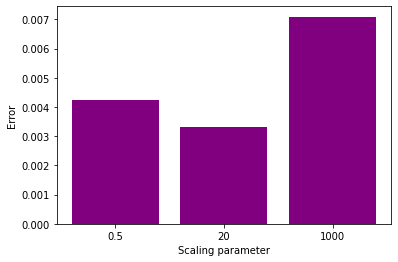

In [ ]:
S = [0.5, 20, 1000]

values = [error(test_y,  MLclf_parzen(train1d_x, train_y, test1d_x, s)) for s in S]
plt.bar([str(s) for s in S], values, color = 'purple')
plt.xlabel('Scaling parameter')
plt.ylabel('Error')
plt.show()

###Exercise 2: K-means clustering###

We flatten our features dataset and use 100 data points for each class.

In [ ]:
train_set_x = mnist_trainset.data.numpy()
train_set_y = mnist_trainset.targets.numpy()
train_set_x = train_set_x.reshape(-1, 784)

In [ ]:
n = 100
classes = np.unique(train_set_y)
m = classes.shape[0]
train_x = np.zeros((m*n, train_set_x.shape[1]))
train_y = np.zeros(m*n)
for i in range(m):
    mask = [(train_set_y == classes[i])]
    train_x[i*n:(i+1)*n] = train_set_x[mask[0]][0:100]
    train_y[i*n:(i+1)*n] = train_set_y[mask[0]][0:100]

In [ ]:
train_x.shape, train_y.shape

((1000, 784), (1000,))

In [ ]:
class KMeans(object):
    """
    Parameters:
    -----------
    X -- np.array
        Matrix of input features
    k -- int
        Number of clusters
    """
    
    def __init__(self, X, k):
        self.X = X
        self.k = k
        
    def initialize_centroids(self):
        """ 
        Returns:
        Array of shape (k, n_features), 
            containing k centroids from the initial points
        """
        z = np.copy(self.X)
        np.random.RandomState(512).shuffle(z)
        return z[:self.k]

             
    def closest_centroid(self, centroids):
        """
        Returns:
        Array of shape (n_examples, ), 
            containing index of the nearest centroid for each point
        """
        closest = []
        for i in range(self.X.shape[0]):
          temp = []
          for j in range(len(centroids)):
            temp.append(np.linalg.norm(self.X[i] - centroids[j]) ** 2)
          closest.append(temp.index(min(temp)))
        return closest

    
    def move_centroids(self, centroids):
        """
        Returns:
        Array of shape (n_clusters, n_features),
        containing the new centroids assigned from the points closest to them
        """      
        closest = self.closest_centroid(centroids)
        for k in range(self.k):
          sum = 0
          for i in range(len(closest)): 
            if closest[i] == k:
              sum += self.X[i]
          centroids[k] = sum / closest.count(k)
        return centroids
        

    def final_centroids(self):
        """
        Returns:
        closest -- clustering labels for our data
        clusters -- list of arrays, containing points of each cluster
        centroids -- array of shape (n_clusters, n_features),
            containing final centroids
        """

        start_centroids = self.initialize_centroids()
        while True:
          centroids = self.move_centroids(start_centroids.copy())
          if np.array_equal(centroids, start_centroids):
            break
          else:
            start_centroids = centroids
        closest = self.closest_centroid(centroids)

        clusters = [np.array([]) for i in range(self.k)]
        for k in range(self.k):
          for i in range(len(closest)):
            if closest[i] == k:
              clusters[k] = np.append(clusters[k], self.X[i]).reshape(-1, self.X.shape[1])

        return closest, clusters, centroids

Let`s check our model using sklearn metrics and 1-d data. We can see that model works well on binary clusterisation.

In [ ]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

def metrics(labels_true, labels):
  print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
  print("Completeness: %0.3f" % completeness_score(labels_true, labels))
  print("V-measure: %0.3f" % v_measure_score(labels_true, labels))

In [ ]:
model = KMeans(train1d_x[:1000, None], 2)
clustering_labels, clusters, final_centrs = model.final_centroids()

In [ ]:
metrics(train_y[:1000], clustering_labels)

Homogeneity: 0.912
Completeness: 0.914
V-measure: 0.913


Now let`s apply your k-means implementation to the multiclass dataset. We will write clustering consistency metric from scratch to score the model.

In [ ]:
def cluster_consistency(labels_true, labels):
    classes = np.unique(labels_true)
    for i in classes:


In [ ]:
cluster_consistency(labels_true, labels)

Obviously, we can`t choose k without analysing the underlying data or running the algorithm and comparing the results for different k's (for example, using elbow method). In our case, 10 must have been the best k value to produce labels for our data, but as far as K-Means works better on well-separated circular clusters of the same size, the cases when we defined k>10 could look more convex and therefore mislead the clusterisation. Also the curse of dimensionality explains the cases when such algorithms perform poorly.

In [ ]:
K = [5, 10, 20, 40]


for k in K:
    model = KMeans(train_x, k)
    clustering_labels, _, _ = model.final_centroids()
    print("Number of clusters:", k)
    metrics(train_y, clustering_labels)

Number of clusters: 5
Homogeneity: 0.377
Completeness: 0.563
V-measure: 0.451
Number of clusters: 10
Homogeneity: 0.421
Completeness: 0.430
V-measure: 0.425
Number of clusters: 20
Homogeneity: 0.582
Completeness: 0.457
V-measure: 0.512
Number of clusters: 40
Homogeneity: 0.669
Completeness: 0.431
V-measure: 0.525
